# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:

import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


In [2]:
device

device(type='cuda', index=0)

## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [12]:

# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)



In [13]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

In [14]:
img_shape

(28, 28, 1)

## 2/ GAN parameters

In [15]:
## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5 

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [16]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(z_dim, h_dim_1) # FILL IN HERE
    self.fc2 = nn.Linear(h_dim_1, h_dim_2)# FILL IN HERE
    self.fc3 = nn.Linear(h_dim_2, self.n_pixels) # FILL IN HERE
  def forward(self, z):
    h = F.leaky_relu(self.fc1(z), negative_slope=0.2) # 1st layer 
    h = F.leaky_relu(self.fc2(h), negative_slope=0.2) # 2nd layer 
    h = F.tanh(self.fc3(h)) #3rd layer
    y = h.view((-1, n_rows, n_cols, n_channels))

    return(y)


In [17]:
class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

  def forward(self, x):
    h = x.view((-1, self.n_pixels)) 
    h = F.leaky_relu(self.fc1(h), negative_slope=0.2)
    h = F.leaky_relu(self.fc2(h), negative_slope=0.2)
    y = F.sigmoid(self.fc3(h))
    return y


Create generator and discriminator 

In [18]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels)
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels)
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [30]:
# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss()

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(-torch.log(d_gen_data))
  #loss_gen = torch.mean(torch.log(1 - d_gen_data))
  return loss_gen


### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [31]:
def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device='cpu') #np.random.normal(0, 1, (r * c, z_dim))
  # np.transpose(, (0,2,3,1))
  gen_imgs = generator(z_random).cpu().detach().numpy()

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 0.0000	Loss_G: 15.4397	D(x): 1.0000	D(G(z)): 0.0000


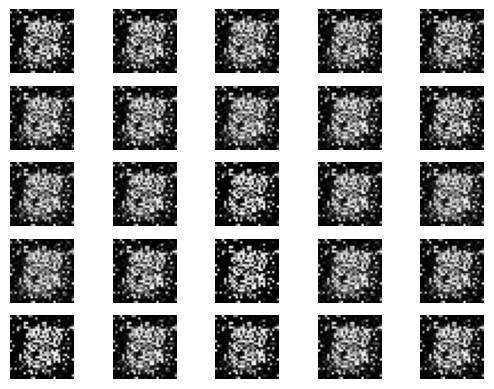

[1/400][0/16] 	Loss_D: 0.0000	Loss_G: 18.4652	D(x): 1.0000	D(G(z)): 0.0000
[2/400][0/16] 	Loss_D: 0.7658	Loss_G: 2.8603	D(x): 0.7643	D(G(z)): 0.3087
[3/400][0/16] 	Loss_D: 1.3811	Loss_G: 2.3621	D(x): 0.6558	D(G(z)): 0.5848
[4/400][0/16] 	Loss_D: 0.6592	Loss_G: 2.7809	D(x): 0.8073	D(G(z)): 0.3501
[5/400][0/16] 	Loss_D: 0.6287	Loss_G: 2.4845	D(x): 0.7843	D(G(z)): 0.3107
[6/400][0/16] 	Loss_D: 0.5575	Loss_G: 2.6850	D(x): 0.8075	D(G(z)): 0.2824
[7/400][0/16] 	Loss_D: 0.7064	Loss_G: 2.6700	D(x): 0.8079	D(G(z)): 0.3653
[8/400][0/16] 	Loss_D: 0.5461	Loss_G: 2.2458	D(x): 0.7905	D(G(z)): 0.2576
[9/400][0/16] 	Loss_D: 1.2111	Loss_G: 0.9324	D(x): 0.4252	D(G(z)): 0.2083
[10/400][0/16] 	Loss_D: 0.7949	Loss_G: 1.9138	D(x): 0.7629	D(G(z)): 0.3966
[11/400][0/16] 	Loss_D: 1.1864	Loss_G: 1.3992	D(x): 0.6221	D(G(z)): 0.4849
[12/400][0/16] 	Loss_D: 1.1044	Loss_G: 2.2497	D(x): 0.8538	D(G(z)): 0.6066
[13/400][0/16] 	Loss_D: 1.1181	Loss_G: 1.0749	D(x): 0.5248	D(G(z)): 0.3271
[14/400][0/16] 	Loss_D: 0.8122	Lo

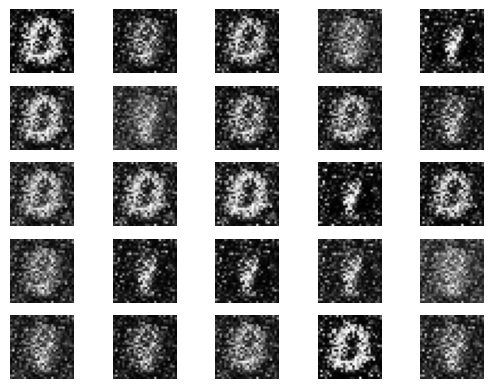

[26/400][0/16] 	Loss_D: 0.8476	Loss_G: 2.2478	D(x): 0.8500	D(G(z)): 0.4885
[27/400][0/16] 	Loss_D: 0.8903	Loss_G: 1.1731	D(x): 0.5913	D(G(z)): 0.2588
[28/400][0/16] 	Loss_D: 0.8613	Loss_G: 1.2047	D(x): 0.6197	D(G(z)): 0.2957
[29/400][0/16] 	Loss_D: 1.0773	Loss_G: 1.7335	D(x): 0.8241	D(G(z)): 0.5780
[30/400][0/16] 	Loss_D: 0.7380	Loss_G: 1.3722	D(x): 0.7012	D(G(z)): 0.2903
[31/400][0/16] 	Loss_D: 1.4759	Loss_G: 2.9111	D(x): 0.9196	D(G(z)): 0.7422
[32/400][0/16] 	Loss_D: 0.6392	Loss_G: 1.6073	D(x): 0.7728	D(G(z)): 0.2986
[33/400][0/16] 	Loss_D: 0.9144	Loss_G: 0.9614	D(x): 0.5529	D(G(z)): 0.2186
[34/400][0/16] 	Loss_D: 0.7650	Loss_G: 2.0967	D(x): 0.8247	D(G(z)): 0.4104
[35/400][0/16] 	Loss_D: 0.9797	Loss_G: 2.0082	D(x): 0.8222	D(G(z)): 0.5103
[36/400][0/16] 	Loss_D: 0.8335	Loss_G: 1.3378	D(x): 0.6969	D(G(z)): 0.3329
[37/400][0/16] 	Loss_D: 0.9778	Loss_G: 1.0245	D(x): 0.5850	D(G(z)): 0.2934
[38/400][0/16] 	Loss_D: 1.1707	Loss_G: 0.7011	D(x): 0.4222	D(G(z)): 0.1512
[39/400][0/16] 	Loss_D: 0

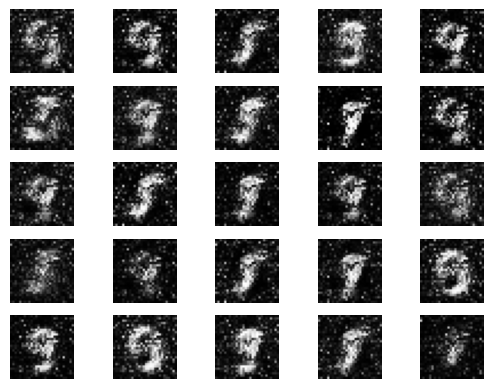

[51/400][0/16] 	Loss_D: 0.8649	Loss_G: 1.1093	D(x): 0.6137	D(G(z)): 0.2594
[52/400][0/16] 	Loss_D: 0.8528	Loss_G: 1.2673	D(x): 0.6253	D(G(z)): 0.2556
[53/400][0/16] 	Loss_D: 0.7520	Loss_G: 2.2625	D(x): 0.7974	D(G(z)): 0.3812
[54/400][0/16] 	Loss_D: 1.0411	Loss_G: 0.7763	D(x): 0.5044	D(G(z)): 0.1824
[55/400][0/16] 	Loss_D: 0.8283	Loss_G: 2.9224	D(x): 0.8729	D(G(z)): 0.4858
[56/400][0/16] 	Loss_D: 0.9222	Loss_G: 0.9714	D(x): 0.5389	D(G(z)): 0.1656
[57/400][0/16] 	Loss_D: 0.6324	Loss_G: 1.5892	D(x): 0.7474	D(G(z)): 0.2634
[58/400][0/16] 	Loss_D: 0.9764	Loss_G: 2.2832	D(x): 0.8865	D(G(z)): 0.5519
[59/400][0/16] 	Loss_D: 0.9133	Loss_G: 2.4350	D(x): 0.8211	D(G(z)): 0.4830
[60/400][0/16] 	Loss_D: 1.1298	Loss_G: 2.1973	D(x): 0.9116	D(G(z)): 0.6190
[61/400][0/16] 	Loss_D: 0.9304	Loss_G: 1.9789	D(x): 0.7921	D(G(z)): 0.4693
[62/400][0/16] 	Loss_D: 0.8460	Loss_G: 0.9415	D(x): 0.5785	D(G(z)): 0.1871
[63/400][0/16] 	Loss_D: 0.7511	Loss_G: 2.0648	D(x): 0.7856	D(G(z)): 0.3728
[64/400][0/16] 	Loss_D: 0

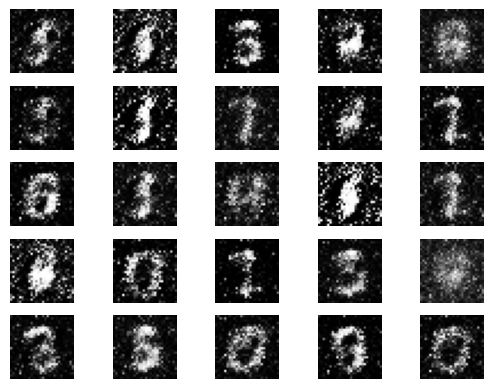

[76/400][0/16] 	Loss_D: 0.6764	Loss_G: 1.5529	D(x): 0.7029	D(G(z)): 0.2071
[77/400][0/16] 	Loss_D: 0.6667	Loss_G: 1.8919	D(x): 0.7577	D(G(z)): 0.2961
[78/400][0/16] 	Loss_D: 0.9843	Loss_G: 0.8437	D(x): 0.5669	D(G(z)): 0.1813
[79/400][0/16] 	Loss_D: 0.9636	Loss_G: 1.8082	D(x): 0.5091	D(G(z)): 0.1144
[80/400][0/16] 	Loss_D: 0.7609	Loss_G: 1.3388	D(x): 0.6537	D(G(z)): 0.2020
[81/400][0/16] 	Loss_D: 0.6931	Loss_G: 1.4910	D(x): 0.6126	D(G(z)): 0.1260
[82/400][0/16] 	Loss_D: 0.6265	Loss_G: 2.0568	D(x): 0.8235	D(G(z)): 0.3292
[83/400][0/16] 	Loss_D: 0.9556	Loss_G: 1.3340	D(x): 0.4956	D(G(z)): 0.0763
[84/400][0/16] 	Loss_D: 0.7395	Loss_G: 2.3700	D(x): 0.8762	D(G(z)): 0.4163
[85/400][0/16] 	Loss_D: 0.6485	Loss_G: 1.8934	D(x): 0.7669	D(G(z)): 0.2835
[86/400][0/16] 	Loss_D: 0.8149	Loss_G: 1.0441	D(x): 0.6421	D(G(z)): 0.1829
[87/400][0/16] 	Loss_D: 0.5876	Loss_G: 2.1175	D(x): 0.7595	D(G(z)): 0.2131
[88/400][0/16] 	Loss_D: 0.5943	Loss_G: 2.7096	D(x): 0.8734	D(G(z)): 0.3385
[89/400][0/16] 	Loss_D: 0

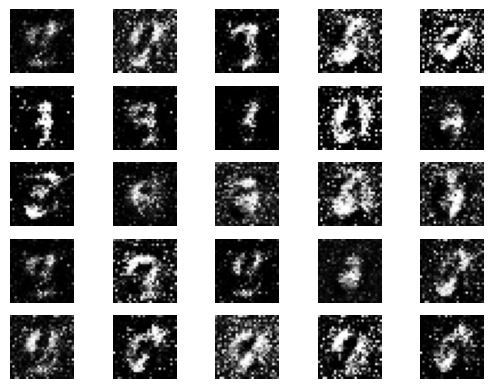

[101/400][0/16] 	Loss_D: 0.6394	Loss_G: 2.1244	D(x): 0.7870	D(G(z)): 0.2883
[102/400][0/16] 	Loss_D: 1.1195	Loss_G: 2.8356	D(x): 0.9068	D(G(z)): 0.5983
[103/400][0/16] 	Loss_D: 1.5318	Loss_G: 0.7050	D(x): 0.3329	D(G(z)): 0.0394
[104/400][0/16] 	Loss_D: 0.6871	Loss_G: 1.6149	D(x): 0.8073	D(G(z)): 0.3435
[105/400][0/16] 	Loss_D: 0.6731	Loss_G: 1.5668	D(x): 0.7390	D(G(z)): 0.2510
[106/400][0/16] 	Loss_D: 0.7194	Loss_G: 1.8345	D(x): 0.6763	D(G(z)): 0.2123
[107/400][0/16] 	Loss_D: 0.6290	Loss_G: 1.8144	D(x): 0.7810	D(G(z)): 0.2704
[108/400][0/16] 	Loss_D: 0.7252	Loss_G: 1.2240	D(x): 0.6221	D(G(z)): 0.1351
[109/400][0/16] 	Loss_D: 0.8437	Loss_G: 2.4345	D(x): 0.7929	D(G(z)): 0.4332
[110/400][0/16] 	Loss_D: 0.7575	Loss_G: 1.2804	D(x): 0.6337	D(G(z)): 0.1827
[111/400][0/16] 	Loss_D: 0.6050	Loss_G: 1.5430	D(x): 0.7716	D(G(z)): 0.2554
[112/400][0/16] 	Loss_D: 0.7749	Loss_G: 1.1825	D(x): 0.6274	D(G(z)): 0.2008
[113/400][0/16] 	Loss_D: 0.7760	Loss_G: 1.8383	D(x): 0.7494	D(G(z)): 0.3363
[114/400][0/

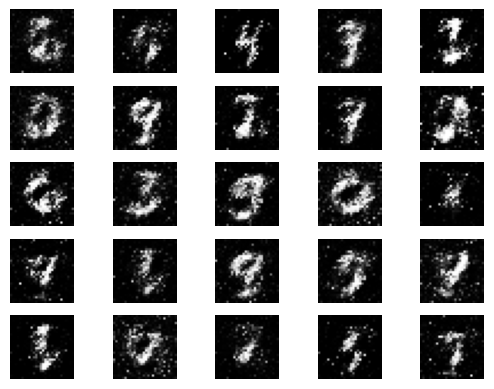

[126/400][0/16] 	Loss_D: 0.6856	Loss_G: 3.1728	D(x): 0.9225	D(G(z)): 0.4320
[127/400][0/16] 	Loss_D: 0.5390	Loss_G: 2.6988	D(x): 0.8884	D(G(z)): 0.3170
[128/400][0/16] 	Loss_D: 0.8423	Loss_G: 3.1324	D(x): 0.8939	D(G(z)): 0.4625
[129/400][0/16] 	Loss_D: 0.5240	Loss_G: 2.4311	D(x): 0.8717	D(G(z)): 0.2949
[130/400][0/16] 	Loss_D: 0.7301	Loss_G: 1.9702	D(x): 0.6681	D(G(z)): 0.1460
[131/400][0/16] 	Loss_D: 0.9252	Loss_G: 1.9399	D(x): 0.5550	D(G(z)): 0.0408
[132/400][0/16] 	Loss_D: 0.7122	Loss_G: 1.4946	D(x): 0.6487	D(G(z)): 0.1183
[133/400][0/16] 	Loss_D: 0.5181	Loss_G: 1.8057	D(x): 0.7675	D(G(z)): 0.1775
[134/400][0/16] 	Loss_D: 0.6259	Loss_G: 1.4666	D(x): 0.7222	D(G(z)): 0.1997
[135/400][0/16] 	Loss_D: 0.6983	Loss_G: 1.6740	D(x): 0.6278	D(G(z)): 0.0897
[136/400][0/16] 	Loss_D: 0.8108	Loss_G: 3.9251	D(x): 0.9490	D(G(z)): 0.4962
[137/400][0/16] 	Loss_D: 0.9206	Loss_G: 1.3763	D(x): 0.5222	D(G(z)): 0.0490
[138/400][0/16] 	Loss_D: 0.6055	Loss_G: 2.5535	D(x): 0.9165	D(G(z)): 0.3747
[139/400][0/

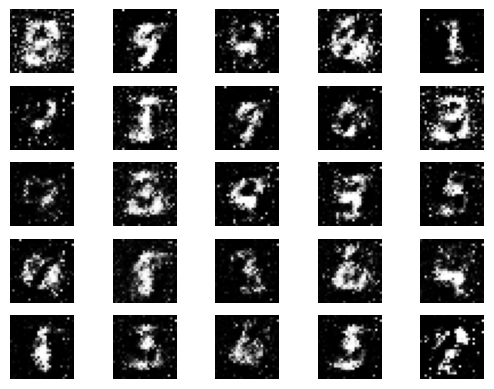

[151/400][0/16] 	Loss_D: 1.4024	Loss_G: 0.9253	D(x): 0.3889	D(G(z)): 0.0244
[152/400][0/16] 	Loss_D: 0.7882	Loss_G: 2.7300	D(x): 0.8990	D(G(z)): 0.4594
[153/400][0/16] 	Loss_D: 0.5313	Loss_G: 2.2180	D(x): 0.8234	D(G(z)): 0.2512
[154/400][0/16] 	Loss_D: 0.7027	Loss_G: 2.5839	D(x): 0.8447	D(G(z)): 0.3749
[155/400][0/16] 	Loss_D: 0.9948	Loss_G: 0.6210	D(x): 0.5288	D(G(z)): 0.0891
[156/400][0/16] 	Loss_D: 1.7699	Loss_G: 1.3042	D(x): 0.3451	D(G(z)): 0.0163
[157/400][0/16] 	Loss_D: 0.4540	Loss_G: 1.9318	D(x): 0.8357	D(G(z)): 0.1728
[158/400][0/16] 	Loss_D: 0.5379	Loss_G: 1.8675	D(x): 0.7390	D(G(z)): 0.1598
[159/400][0/16] 	Loss_D: 0.4987	Loss_G: 1.9403	D(x): 0.7951	D(G(z)): 0.2027
[160/400][0/16] 	Loss_D: 0.5000	Loss_G: 2.1052	D(x): 0.8309	D(G(z)): 0.2423
[161/400][0/16] 	Loss_D: 0.5292	Loss_G: 1.9600	D(x): 0.7289	D(G(z)): 0.1274
[162/400][0/16] 	Loss_D: 0.5968	Loss_G: 2.8281	D(x): 0.9095	D(G(z)): 0.3754
[163/400][0/16] 	Loss_D: 0.7821	Loss_G: 1.3844	D(x): 0.6346	D(G(z)): 0.1132
[164/400][0/

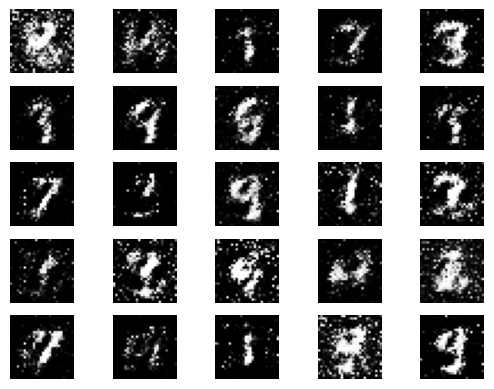

[176/400][0/16] 	Loss_D: 0.5039	Loss_G: 2.6059	D(x): 0.8612	D(G(z)): 0.2592
[177/400][0/16] 	Loss_D: 0.8104	Loss_G: 3.9045	D(x): 0.9143	D(G(z)): 0.4801
[178/400][0/16] 	Loss_D: 0.5713	Loss_G: 2.5911	D(x): 0.8708	D(G(z)): 0.3107
[179/400][0/16] 	Loss_D: 0.6321	Loss_G: 1.7739	D(x): 0.7248	D(G(z)): 0.1431
[180/400][0/16] 	Loss_D: 0.4771	Loss_G: 1.6178	D(x): 0.7736	D(G(z)): 0.1408
[181/400][0/16] 	Loss_D: 0.9874	Loss_G: 1.4609	D(x): 0.5074	D(G(z)): 0.0714
[182/400][0/16] 	Loss_D: 0.4788	Loss_G: 2.6127	D(x): 0.7974	D(G(z)): 0.1689
[183/400][0/16] 	Loss_D: 0.7901	Loss_G: 3.8451	D(x): 0.9203	D(G(z)): 0.4792
[184/400][0/16] 	Loss_D: 1.0141	Loss_G: 3.3239	D(x): 0.9523	D(G(z)): 0.5659
[185/400][0/16] 	Loss_D: 1.1804	Loss_G: 1.3270	D(x): 0.4503	D(G(z)): 0.0224
[186/400][0/16] 	Loss_D: 0.5410	Loss_G: 2.4460	D(x): 0.8677	D(G(z)): 0.2940
[187/400][0/16] 	Loss_D: 0.5729	Loss_G: 1.2146	D(x): 0.7076	D(G(z)): 0.1180
[188/400][0/16] 	Loss_D: 0.4897	Loss_G: 2.1006	D(x): 0.8114	D(G(z)): 0.1951
[189/400][0/

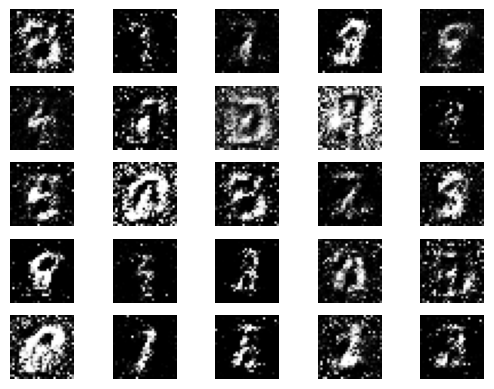

[201/400][0/16] 	Loss_D: 0.8702	Loss_G: 1.2079	D(x): 0.5486	D(G(z)): 0.0618
[202/400][0/16] 	Loss_D: 0.9011	Loss_G: 2.3000	D(x): 0.9083	D(G(z)): 0.4789
[203/400][0/16] 	Loss_D: 0.7017	Loss_G: 2.7700	D(x): 0.8537	D(G(z)): 0.3682
[204/400][0/16] 	Loss_D: 0.5486	Loss_G: 2.0521	D(x): 0.7029	D(G(z)): 0.0725
[205/400][0/16] 	Loss_D: 0.6028	Loss_G: 1.2398	D(x): 0.6535	D(G(z)): 0.0661
[206/400][0/16] 	Loss_D: 2.6538	Loss_G: 1.0374	D(x): 0.1943	D(G(z)): 0.0086
[207/400][0/16] 	Loss_D: 0.5128	Loss_G: 2.1304	D(x): 0.8212	D(G(z)): 0.2340
[208/400][0/16] 	Loss_D: 1.1169	Loss_G: 4.2912	D(x): 0.9625	D(G(z)): 0.6165
[209/400][0/16] 	Loss_D: 0.5000	Loss_G: 1.8083	D(x): 0.7726	D(G(z)): 0.1242
[210/400][0/16] 	Loss_D: 0.4328	Loss_G: 2.1463	D(x): 0.8257	D(G(z)): 0.1742
[211/400][0/16] 	Loss_D: 0.4348	Loss_G: 1.8309	D(x): 0.8159	D(G(z)): 0.1451
[212/400][0/16] 	Loss_D: 0.4418	Loss_G: 2.3332	D(x): 0.7598	D(G(z)): 0.0863
[213/400][0/16] 	Loss_D: 0.6034	Loss_G: 3.3114	D(x): 0.9057	D(G(z)): 0.3524
[214/400][0/

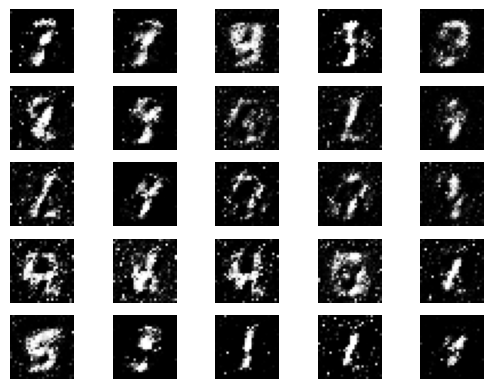

[226/400][0/16] 	Loss_D: 0.6127	Loss_G: 2.1645	D(x): 0.7775	D(G(z)): 0.2353
[227/400][0/16] 	Loss_D: 0.7900	Loss_G: 1.0853	D(x): 0.6146	D(G(z)): 0.0646
[228/400][0/16] 	Loss_D: 2.9536	Loss_G: 2.1618	D(x): 0.2041	D(G(z)): 0.0014
[229/400][0/16] 	Loss_D: 0.6731	Loss_G: 3.4338	D(x): 0.8875	D(G(z)): 0.3796
[230/400][0/16] 	Loss_D: 0.6506	Loss_G: 3.1409	D(x): 0.8984	D(G(z)): 0.3804
[231/400][0/16] 	Loss_D: 0.4813	Loss_G: 3.0737	D(x): 0.8817	D(G(z)): 0.2576
[232/400][0/16] 	Loss_D: 0.7295	Loss_G: 1.2764	D(x): 0.6268	D(G(z)): 0.0769
[233/400][0/16] 	Loss_D: 0.4952	Loss_G: 2.3343	D(x): 0.8642	D(G(z)): 0.2426
[234/400][0/16] 	Loss_D: 2.3109	Loss_G: 1.8456	D(x): 0.2834	D(G(z)): 0.0074
[235/400][0/16] 	Loss_D: 0.8113	Loss_G: 0.8335	D(x): 0.5775	D(G(z)): 0.0764
[236/400][0/16] 	Loss_D: 0.6988	Loss_G: 1.2492	D(x): 0.6739	D(G(z)): 0.1323
[237/400][0/16] 	Loss_D: 0.8549	Loss_G: 1.4660	D(x): 0.5863	D(G(z)): 0.0489
[238/400][0/16] 	Loss_D: 0.4353	Loss_G: 2.0470	D(x): 0.8828	D(G(z)): 0.2280
[239/400][0/

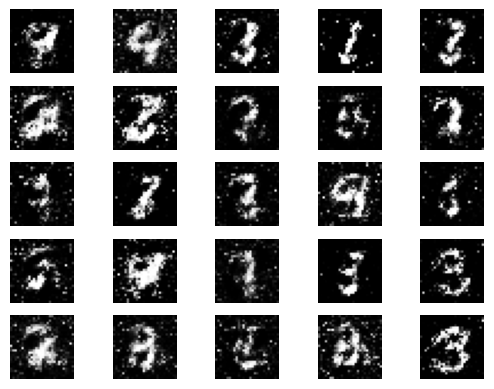

[251/400][0/16] 	Loss_D: 0.5166	Loss_G: 2.4234	D(x): 0.8990	D(G(z)): 0.3075
[252/400][0/16] 	Loss_D: 0.6768	Loss_G: 1.6072	D(x): 0.6921	D(G(z)): 0.1320
[253/400][0/16] 	Loss_D: 0.4827	Loss_G: 2.1200	D(x): 0.7665	D(G(z)): 0.1257
[254/400][0/16] 	Loss_D: 0.7711	Loss_G: 3.9487	D(x): 0.9534	D(G(z)): 0.4624
[255/400][0/16] 	Loss_D: 0.7536	Loss_G: 1.3170	D(x): 0.6233	D(G(z)): 0.1313
[256/400][0/16] 	Loss_D: 0.6471	Loss_G: 3.1270	D(x): 0.9267	D(G(z)): 0.3810
[257/400][0/16] 	Loss_D: 0.4801	Loss_G: 2.4134	D(x): 0.8797	D(G(z)): 0.2525
[258/400][0/16] 	Loss_D: 0.5462	Loss_G: 3.0035	D(x): 0.8546	D(G(z)): 0.2771
[259/400][0/16] 	Loss_D: 0.6433	Loss_G: 2.9702	D(x): 0.8911	D(G(z)): 0.3656
[260/400][0/16] 	Loss_D: 1.4253	Loss_G: 4.4809	D(x): 0.9835	D(G(z)): 0.6943
[261/400][0/16] 	Loss_D: 0.6892	Loss_G: 1.6740	D(x): 0.6342	D(G(z)): 0.0798
[262/400][0/16] 	Loss_D: 0.5788	Loss_G: 1.7739	D(x): 0.6985	D(G(z)): 0.1170
[263/400][0/16] 	Loss_D: 0.5186	Loss_G: 2.2853	D(x): 0.8595	D(G(z)): 0.2649
[264/400][0/

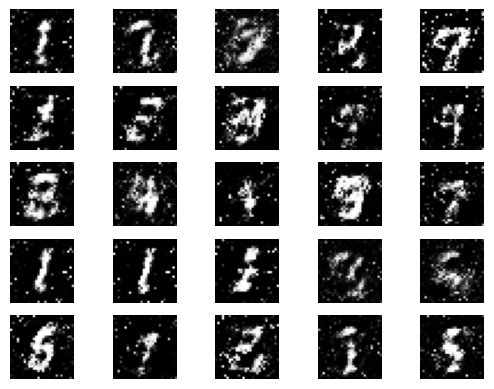

[276/400][0/16] 	Loss_D: 0.5020	Loss_G: 2.1451	D(x): 0.7797	D(G(z)): 0.1611
[277/400][0/16] 	Loss_D: 0.7590	Loss_G: 0.8996	D(x): 0.6081	D(G(z)): 0.0815
[278/400][0/16] 	Loss_D: 0.6219	Loss_G: 1.3557	D(x): 0.7042	D(G(z)): 0.1658
[279/400][0/16] 	Loss_D: 0.4781	Loss_G: 2.3313	D(x): 0.8070	D(G(z)): 0.1798
[280/400][0/16] 	Loss_D: 0.5667	Loss_G: 2.6053	D(x): 0.8420	D(G(z)): 0.2581
[281/400][0/16] 	Loss_D: 0.4806	Loss_G: 1.8639	D(x): 0.7490	D(G(z)): 0.1222
[282/400][0/16] 	Loss_D: 0.5139	Loss_G: 2.1466	D(x): 0.8020	D(G(z)): 0.2004
[283/400][0/16] 	Loss_D: 0.6493	Loss_G: 2.8267	D(x): 0.8822	D(G(z)): 0.3584
[284/400][0/16] 	Loss_D: 0.9945	Loss_G: 0.7577	D(x): 0.5049	D(G(z)): 0.0558
[285/400][0/16] 	Loss_D: 0.5534	Loss_G: 1.9056	D(x): 0.7688	D(G(z)): 0.2090
[286/400][0/16] 	Loss_D: 0.5016	Loss_G: 2.1622	D(x): 0.8755	D(G(z)): 0.2692
[287/400][0/16] 	Loss_D: 0.6557	Loss_G: 1.7659	D(x): 0.7810	D(G(z)): 0.2780
[288/400][0/16] 	Loss_D: 0.8887	Loss_G: 3.8633	D(x): 0.9197	D(G(z)): 0.4948
[289/400][0/

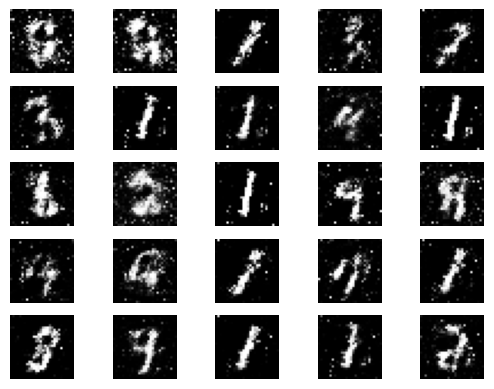

[301/400][0/16] 	Loss_D: 0.6197	Loss_G: 3.3985	D(x): 0.9421	D(G(z)): 0.4006
[302/400][0/16] 	Loss_D: 0.5229	Loss_G: 1.8658	D(x): 0.7959	D(G(z)): 0.2029
[303/400][0/16] 	Loss_D: 0.6070	Loss_G: 2.6662	D(x): 0.8659	D(G(z)): 0.3211
[304/400][0/16] 	Loss_D: 0.5067	Loss_G: 1.7909	D(x): 0.8482	D(G(z)): 0.2390
[305/400][0/16] 	Loss_D: 0.7021	Loss_G: 1.3563	D(x): 0.7494	D(G(z)): 0.2522
[306/400][0/16] 	Loss_D: 1.4809	Loss_G: 1.1768	D(x): 0.4171	D(G(z)): 0.0188
[307/400][0/16] 	Loss_D: 0.6812	Loss_G: 1.0568	D(x): 0.6839	D(G(z)): 0.1639
[308/400][0/16] 	Loss_D: 0.5833	Loss_G: 1.7892	D(x): 0.7872	D(G(z)): 0.2415
[309/400][0/16] 	Loss_D: 0.7584	Loss_G: 2.3548	D(x): 0.8880	D(G(z)): 0.4217
[310/400][0/16] 	Loss_D: 0.5629	Loss_G: 1.5550	D(x): 0.7086	D(G(z)): 0.0885
[311/400][0/16] 	Loss_D: 0.6957	Loss_G: 0.9735	D(x): 0.6393	D(G(z)): 0.0747
[312/400][0/16] 	Loss_D: 0.5972	Loss_G: 2.1583	D(x): 0.8104	D(G(z)): 0.2719
[313/400][0/16] 	Loss_D: 0.6021	Loss_G: 2.3475	D(x): 0.8243	D(G(z)): 0.2845
[314/400][0/

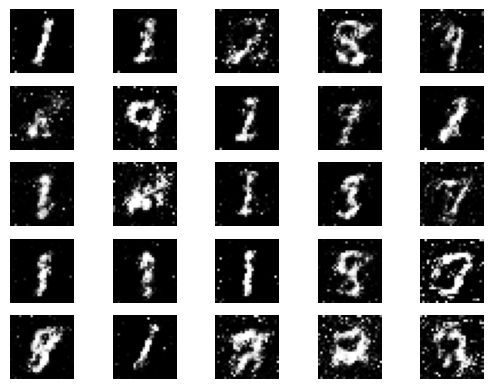

[326/400][0/16] 	Loss_D: 0.8891	Loss_G: 3.8643	D(x): 0.9315	D(G(z)): 0.5120
[327/400][0/16] 	Loss_D: 0.6334	Loss_G: 2.1735	D(x): 0.8502	D(G(z)): 0.3352
[328/400][0/16] 	Loss_D: 0.6074	Loss_G: 1.2259	D(x): 0.7137	D(G(z)): 0.1769
[329/400][0/16] 	Loss_D: 0.7668	Loss_G: 1.1912	D(x): 0.6180	D(G(z)): 0.1136
[330/400][0/16] 	Loss_D: 0.6096	Loss_G: 2.4241	D(x): 0.8361	D(G(z)): 0.2961
[331/400][0/16] 	Loss_D: 0.5681	Loss_G: 2.0747	D(x): 0.8025	D(G(z)): 0.2518
[332/400][0/16] 	Loss_D: 0.6102	Loss_G: 3.2026	D(x): 0.9162	D(G(z)): 0.3666
[333/400][0/16] 	Loss_D: 1.0181	Loss_G: 3.9199	D(x): 0.9304	D(G(z)): 0.5429
[334/400][0/16] 	Loss_D: 0.6808	Loss_G: 2.4475	D(x): 0.8421	D(G(z)): 0.3435
[335/400][0/16] 	Loss_D: 0.6713	Loss_G: 2.3167	D(x): 0.8093	D(G(z)): 0.3061
[336/400][0/16] 	Loss_D: 0.6533	Loss_G: 2.5144	D(x): 0.8635	D(G(z)): 0.3522
[337/400][0/16] 	Loss_D: 0.8182	Loss_G: 3.1990	D(x): 0.8921	D(G(z)): 0.4514
[338/400][0/16] 	Loss_D: 0.5398	Loss_G: 2.3575	D(x): 0.8623	D(G(z)): 0.2958
[339/400][0/

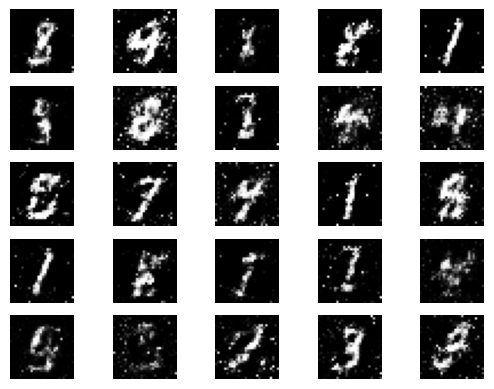

[351/400][0/16] 	Loss_D: 0.5916	Loss_G: 1.1110	D(x): 0.7204	D(G(z)): 0.1405
[352/400][0/16] 	Loss_D: 1.3785	Loss_G: 3.5197	D(x): 0.9573	D(G(z)): 0.6427
[353/400][0/16] 	Loss_D: 1.0366	Loss_G: 3.8098	D(x): 0.9070	D(G(z)): 0.5570
[354/400][0/16] 	Loss_D: 1.3677	Loss_G: 0.5200	D(x): 0.4063	D(G(z)): 0.0411
[355/400][0/16] 	Loss_D: 0.5337	Loss_G: 1.6565	D(x): 0.7757	D(G(z)): 0.1941
[356/400][0/16] 	Loss_D: 0.5638	Loss_G: 2.1261	D(x): 0.7985	D(G(z)): 0.2386
[357/400][0/16] 	Loss_D: 0.6921	Loss_G: 1.2356	D(x): 0.6932	D(G(z)): 0.1901
[358/400][0/16] 	Loss_D: 0.6501	Loss_G: 2.5471	D(x): 0.8221	D(G(z)): 0.2922
[359/400][0/16] 	Loss_D: 0.5730	Loss_G: 2.1600	D(x): 0.8317	D(G(z)): 0.2685
[360/400][0/16] 	Loss_D: 0.5102	Loss_G: 1.7062	D(x): 0.8023	D(G(z)): 0.2124
[361/400][0/16] 	Loss_D: 0.6433	Loss_G: 2.1639	D(x): 0.6684	D(G(z)): 0.0850
[362/400][0/16] 	Loss_D: 0.5915	Loss_G: 2.4816	D(x): 0.8386	D(G(z)): 0.2906
[363/400][0/16] 	Loss_D: 0.5410	Loss_G: 1.7807	D(x): 0.7855	D(G(z)): 0.1875
[364/400][0/

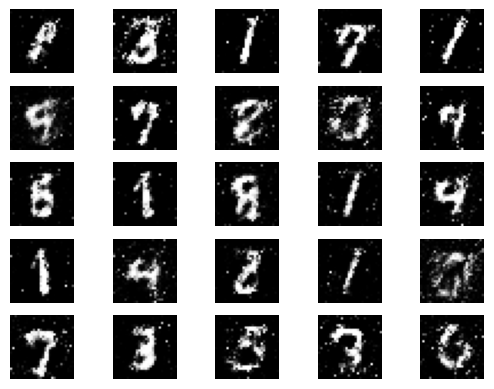

[376/400][0/16] 	Loss_D: 0.6343	Loss_G: 1.8023	D(x): 0.7898	D(G(z)): 0.2723
[377/400][0/16] 	Loss_D: 0.5661	Loss_G: 1.6231	D(x): 0.7766	D(G(z)): 0.2057
[378/400][0/16] 	Loss_D: 0.6415	Loss_G: 1.6026	D(x): 0.7135	D(G(z)): 0.1814
[379/400][0/16] 	Loss_D: 0.9514	Loss_G: 0.6819	D(x): 0.5010	D(G(z)): 0.0681
[380/400][0/16] 	Loss_D: 0.9445	Loss_G: 2.8687	D(x): 0.8903	D(G(z)): 0.4736
[381/400][0/16] 	Loss_D: 0.6399	Loss_G: 1.3970	D(x): 0.7005	D(G(z)): 0.1798
[382/400][0/16] 	Loss_D: 0.6064	Loss_G: 1.7512	D(x): 0.7672	D(G(z)): 0.2213
[383/400][0/16] 	Loss_D: 0.6115	Loss_G: 1.1986	D(x): 0.6761	D(G(z)): 0.1062
[384/400][0/16] 	Loss_D: 0.7092	Loss_G: 0.9541	D(x): 0.6408	D(G(z)): 0.0996
[385/400][0/16] 	Loss_D: 0.8083	Loss_G: 1.1561	D(x): 0.6455	D(G(z)): 0.1694
[386/400][0/16] 	Loss_D: 0.8396	Loss_G: 0.8284	D(x): 0.5952	D(G(z)): 0.0907
[387/400][0/16] 	Loss_D: 0.6736	Loss_G: 2.3855	D(x): 0.8633	D(G(z)): 0.3384
[388/400][0/16] 	Loss_D: 0.9675	Loss_G: 0.8343	D(x): 0.5422	D(G(z)): 0.0851
[389/400][0/

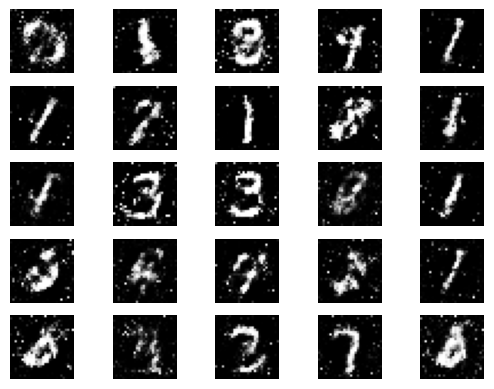

In [32]:
# Training Loop

# disc_model.to(device)
# gen_model.to(device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0] #accessing the tensors inside the list
      # true_imgs.shape = ([number_of_imgs, channels, img_rows, img_cols])
      true_labels = torch.ones((true_imgs.shape[0],1), dtype=torch.float)
      # put true data through discriminator
      d_output_true = disc_model(true_imgs)
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true, true_labels)
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = np.random.normal(0, 1, (true_imgs.shape[0], z_dim))
      # Generate batch of fake images
      fake_imgs = gen_model.forward(torch.from_numpy(z_latent_noise).float())
      fake_labels = torch.zeros((true_imgs.shape[0],1), dtype=torch.float)
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs)
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake, fake_labels)
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward(retain_graph=True )
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake =  disc_model(fake_imgs)
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake)
    # backpropagation for generator
    g_loss.backward(retain_graph=True)
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

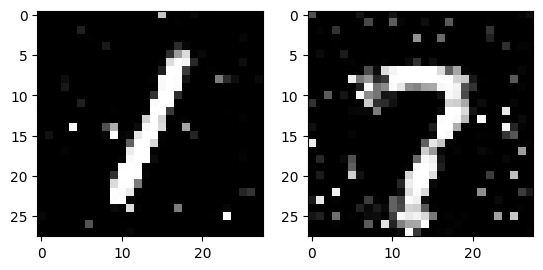

In [45]:
# first image
random_seed = 110 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = np.random.normal(0, 1, (1, z_dim))
x_0 = gen_model.forward(torch.from_numpy(z_0).float()) 

random_seed = 60 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = np.random.normal(0, 1, (1, z_dim))
x_1 = gen_model.forward(torch.from_numpy(z_1).float())

# display images
# FILL IN HERE
plt.figure()
plt.subplot(1,2,1)
plt.imshow(x_0.detach().numpy().reshape(28,28), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_1.detach().numpy().reshape(28,28), cmap='gray')
plt.show()

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [46]:
n_interpolation = 20
# FILL IN HERE
z_interpolation = np.zeros((n_interpolation, z_dim))
for i in range(n_interpolation):
    z_interpolation[i,:] = z_0 + i/(n_interpolation-1)*(z_1-z_0)

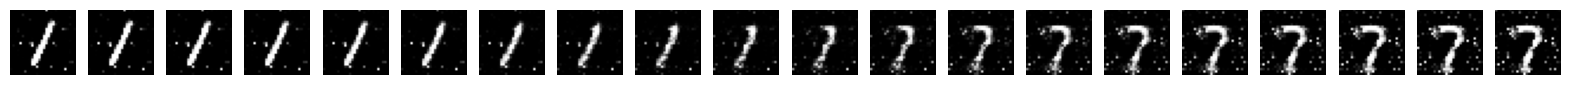

In [47]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  im = gen_model.forward(torch.from_numpy(z_interpolation[i,:]).float()).detach().numpy().reshape(28,28)
  axs[i].imshow(im, cmap='gray')
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__: The quality of the output images is not very good. The images are blurry, there are some artifacts and some digits are not very clear. This maybe can be explained due to the fact that the generator is not trained enough. Although, the images are not very good, we can still see that the interpolation is working well. The digits are changing smoothly from one to another. 

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [ ]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'

learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = torch.nn.Sequential(
    nn.Conv2d(n_h_0, n_h_1, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.Conv2d(n_h_1, n_h_2, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(pool_size, stride=(2, 2)),
    nn.Flatten(),
    nn.Linear(14*14*n_h_2, nb_classes),
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)

In [ ]:
# training the classifier

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):
    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))

# FILL IN HERE

### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [ ]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.argmax(classification_model(imgs_in),dim=1)
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [ ]:
imgs = gen_model.forward(torch.from_numpy(z_interpolation).float()).view(-1,1,28,28)
z_classes = predict_mnist_class(imgs, mnist_classification_model) 
print(z_classes)

__Answer__

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [ ]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = ... # FILL IN HERE
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [ ]:
z_confidence = ... #FILL IN HERE
print(z_confidence)

Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

__Answer__

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE